<div hidden>
$\DeclareMathOperator{\tr}{tr}$
$\DeclareMathOperator{\sign}{sign}$
$\DeclareMathOperator{\argmin}{argmin}$
</div>

# Trace regression

Existem problemas de regressão cujo parâmetro tem estrutura de matriz. Estimar e fazer inferência preservando a estrutura de matriz é em certos casos essencial, especialmente quando o parâmetro tem posto pequeno apesar de ser denso. Neste projeto iremos implementar métodos iterativos para achar a solução do seguinte estimador de mínimos quadrados regularizado:

$$
\min_{B\in\mathbb{R}^{d_1\times d_2}}f(B)=\frac{1}{2n}\sum_{i=1}^n(y_i-tr(X_i^\top B) ))^2 + 
\lambda\Vert B\Vert_N, 
$$
onde $(y_1,X_1), \ldots, (y_n,X_n)$ é uma amostra de labels/features em $\mathbb{R}\times\mathbb{R}^{d_1\times d_2}$. Àcima, $\lambda>0$ é um hyper-parâmetro positivo e 

$$
\Vert B\Vert_N := \sum_{j=1}^{\min\{d_1,d_2\}}\sigma(B),
$$

é a *norma nuclear* da matriz $B$, onde $\sigma_1(B)\ge\cdots\ge\sigma_{\min\{d_1,d_2\}}(B)$ são os valores singulares de $B$.  

# Soft-Thresholding matricial

Recorde que o passo de iteração do método gradiente proximal é calcular o *operador proximal* da norma $\lambda\Vert\cdot\Vert_N$:
$$
P(W,\lambda)\in\argmin_{B\in\mathbb{R}^{d_1\times d_2}}\left\{
\frac{1}{2}\Vert W - B\Vert_F^2 + \lambda\Vert B\Vert_N
\right\}.
$$


$P(W,\lambda)$ tem fórmula explicíta. Dados $\gamma\in\mathbb{R}$, defina
$$
S(\gamma,\lambda):=sign(\gamma)\cdot\max\{\gamma-\lambda,0\}.
$$
Àcima, $sign(\gamma)$ é o sinal de $\gamma$. Seja agora a decomposição de valores singulares (SVD) de $W$:
$$
W = U\cdot D(\gamma_1,\ldots,\gamma_r)\cdot V^\top.
$$
Então, 
$$
P(W,\lambda) = U\cdot D\left( S(\gamma_1,\lambda),\ldots, S(\gamma_r,\lambda)\right)\cdot V^\top, 
$$
chamado de matriz *soft-thresholding* de $W$ com threshold $\lambda$.

In [1]:
import matplotlib
import numpy as np
import scipy
from scipy.stats import ortho_group
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la

# Exercício 1: Gerando dados

Construa uma função ``data_genP(d1,d2,r,B_mag)`` que toma $d_1$, $d_2$, posto $r$ e número positivo ``B_mag`` e retorna a matriz $d_1\times d_2$ de posto $r$ e valores singulares todos iguais a ``B_mag``. Ao gerar esta matriz $B^*$, use a função ```scipy.stats.ortho_group``` para construir duas matrizes $U$ e $V$ aleatórias ortogonais de dimensões $d_1\times r$ e $d_2\times r$ respectivamente; retorne
$B^*=U\cdot D(B_{mag},\ldots,B_{mag})\cdot V^\top$. 

In [2]:
#Escreva código aqui
def data_genP(d1:int, d2:int, r:int, B_mag:float) -> np.ndarray:
    U = ortho_group.rvs(d1)[:, :r]
    V = ortho_group.rvs(d2)[:, :r]
    D = B_mag * np.eye(r, r)

    B = U @ D @ V.T
    return B

In [3]:
#Exemplo:
d_1=30
d_2=50
r=5
B_mag=10
B_true = data_genP(d_1,d_2,r,B_mag)
B_true.shape

(30, 50)

# Exercício:

Construa uma função ``data_genXe(n,d_1,d_2,B_true,sd)`` que toma $n$, $d_1$, $d_2$, $B_{\text{true}}$ e um número positivo ``sd`` e constrói os dados ``X``, uma lista de $n$ matrizes $X_i$ de dimensão $d_1\times d_2$ independentes cujas entradas são iid normais padrão. A função também retorna o vetor ``y`` de dimensão $n$ cujas coordenadas satisfazem

$$
y_i = tr(X_i^\top B_{\text{true}}) + \text{sd}\cdot\epsilon_i,
$$
onde $\{\epsilon_i\}_{i=1}^n$ é uma sequência iid de normais padrão. 

In [4]:
#Escreva código aqui
def data_genXe(n:int, d_1:int, d_2:int, B_true:np.ndarray, sd:float) -> tuple[np.ndarray]:
    X = [np.random.normal(0, 1, (d_1, d_2)) for i in range(n)]
    y = np.zeros(n)
    
    for i in range(n):
        y[i] = np.trace(X[i].T @ B_true) + sd * np.random.normal(0, 1)

    return X, y.reshape(-1, 1)

In [5]:
#Exemplo:
sd = 2
n = 100

B_true = data_genP(d_1,d_2,r,B_mag)
X,y = data_genXe(n,d_1,d_2,B_true,sd)

In [6]:
type(X), len(X), X[0].shape

(list, 100, (30, 50))

In [7]:
type(y), len(y), y.shape

(numpy.ndarray, 100, (100, 1))

# Exercício:

Construa uma função ``soft(x,l)`` que retorna $S(x,\lambda)$.

In [8]:
#Escreva código aqui
def soft(x:np.ndarray, l:float) -> np.ndarray:
    return np.sign(x) * np.maximum(np.abs(x) - l, 0)

# Exercício 2: 

Vamos usar o método gradiente proximal para resolver o problema àcima:

\begin{align*}
W_{k+1} &:= B_k - \frac{1}{L}\nabla f(B_k),\\
B_{k+1} &:= P\left(W_{k+1},\frac{\lambda}{L}\right).
\end{align*}

Construa uma função ``trace_reg(n,d_1,d_2,X,y,L,lambd,B0,t_final)`` onde, $1/L$ é o passo, ``lambd`` ($=\lambda$) é o fator de penalização, ``B0`` é o ponto inicial, a variável ``t_final`` é o número de iterações. A função deve retornar a sequência $k\mapsto\frac{1}{2n}\sum_{i=1}^n(y_i-Tr(X_i^\top B_k))^2$ e o último iterado $B_{tfinal}$. Use penalização

$$
\lambda = \text{sd}\sqrt{\frac{d_1+d_2}{n}}, 
$$

e passo $A/L$ ajustando $A\ge1$ com

$$
L = A \cdot \lambda_{\max}\left(
\frac{1}{n}\sum_{i=1}^n\text{vec}(X_i)\text{vec}^\top(X_i)
\right),
$$ 
onde $\text{vec}(X_i)$ representa a matrix $d_1\times d_2$ $X_i$ em forma vetorial de dimensão $d_1d_2$. 

**TEM QUE ENTENDER COMO CALCULAR O GRADIENTE}!**

In [9]:
#Escreva código aqui
def trace_reg(n:int, d_1:int, d_2:int, X:np.ndarray, y:np.ndarray, L:float, lambd, B0, t_final):
    B_k = B0
    loss_history = []

    for t in range(t_final):
        loss = 0

        grad_f_Bk = np.zeros_like(B_k)
        for i in range(n):
            grad_f_Bk -= (y[i] - np.trace(X[i].T @ B_k)) * X[i]
            loss += (y[i] - np.trace(X[i].T @ B_k))**2

        grad_f_Bk /= n
        loss_history.append(loss / (2 * n))

        W_k1 = B_k - (1 / L) * grad_f_Bk

        U, S, Vt = np.linalg.svd(W_k1, full_matrices=False)
        S_soft = soft(S, lambd/L)

        B_k1 = U @ np.diag(S_soft) @ Vt
        B_k = B_k1

    return loss_history, B_k1

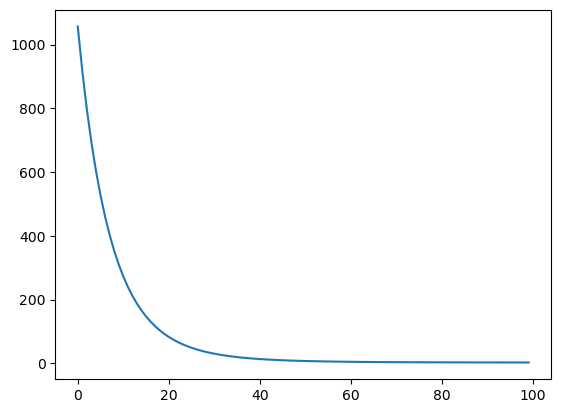

In [10]:
#Exemplo:
B0 = np.ones((d_1,d_2))
t_final = 100

#Cálculo de L:
aux = []
for i in range(n):
    xi = np.asarray(X[i])
    aux.append(xi @ xi.T)
L = 4*np.max(la.eigvalsh(sum(aux)/n))


lambd = sd*np.sqrt((d_1+d_2)/n)      

f1 = trace_reg(n,d_1,d_2,X,y,L,lambd,B0,t_final)
plt.plot(f1[0])

# Exercício: 

O que acontece se $A$ for muito pequeno? 

# Exercício 3: 

Agora, vamos usar o método gradiente proximal acelerado: iniciando de `B0=Z0` e $t_0=1$:

\begin{align*}
Z_{k+1}&:= P\left(
B_k - (1/L)\nabla f(B_k), \frac{\lambda}{L}
\right),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
B_{k+1} &:= Z_{k+1} + \frac{t_{k}-1}{t_{k+1}}(Z_{k+1} - Z_{k}).
\end{align*}

Construa uma função ``trace_reg_acc(n,d_1,d_2,X,y,L,lambd,B0,t_final)`` onde, $1/L$ é o passo, ``lambd`` ($=\lambda$) é o fator de penalização, ``B0`` é o ponto inicial, a variável ``t_final`` é o número de iterações. A função deve retornar a sequência $k\mapsto\frac{1}{2n}\sum_{i=1}^n(y_i-\tr(X_i^\top B_k))^2$ e o último iterado $B_{\text{t_final}}$. Use penalização

$$
\lambda = \text{sd}\sqrt{\frac{d_1+d_2}{n}}, 
$$

e passo $A/L$ ajustando $A\ge1$ com

$$
L = ??,
$$ 

In [11]:
#Escreva código aqui

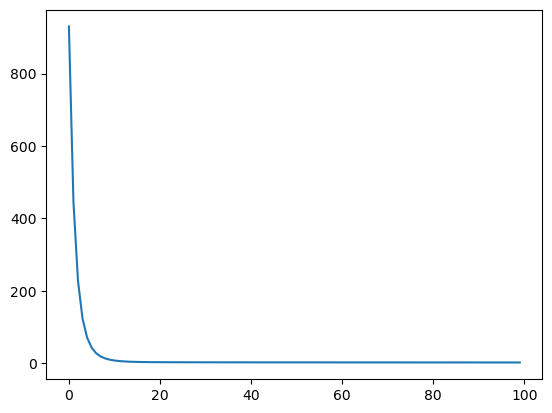

In [12]:
#Exemplo: 
B0 = np.ones((d_1,d_2))
t_final = 100
L = 50
#L = 4*np.max(la.eigvalsh(X.T @ X / X.shape[0]))
lambd = sd*np.sqrt((d_1+d_2)/n)      

f2 = trace_reg(n,d_1,d_2,X,y,L,lambd,B0,t_final)
plt.plot(f2[0])

# Exercício 4: 

Implemente num mesmo gráfico os erros $k\mapsto\frac{1}{2n}\sum_{i=1}^n(y_i-\tr(X_i^\top B_k))^2$ de cada método em função no número de iterações.

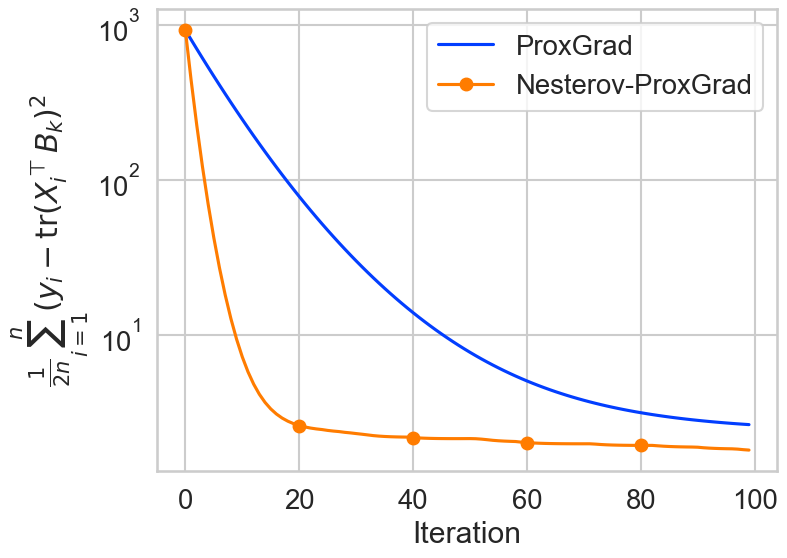

In [13]:
#Escreva código aqui

# Exercício:

Refaça os exercícios com $\sigma=1$ e $\sigma=10$. Qual a diferença quando $\sigma=10$? Tem alguma intuição de porque isso acontece?